In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz


In [21]:
train_X = mnist.train.images
train_Y = mnist.train.labels
test_X = mnist.test.images
test_Y = mnist.test.labels
n_input = 784
n_hidden_1 = 256

In [22]:
x = tf.placeholder("float",[None,n_input])
y = tf.placeholder("float",[None,n_input])
dropout_keep_prob = tf.placeholder("float")

weights = {
    'h1': tf.Variable(tf.random_normal([n_input,n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1,n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1,n_input]))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_1])),
    'out': tf.Variable(tf.zeros([n_input]))
}

In [23]:
def denoise_auto_encoder(_X,_weights,_biases,_keep_prob):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X,_weights['h1']),_biases['b1']))
    layer1_out = tf.nn.dropout(layer_1,_keep_prob)
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1_out,_weights['h2']),_biases['b2']))
    layer2_out = tf.nn.dropout(layer_2,_keep_prob)
    return tf.nn.sigmoid(tf.matmul(layer2_out,_weights['out']) + _biases['out'])

reconstruction = denoise_auto_encoder(x,weights,biases,dropout_keep_prob)

cost = tf.reduce_mean(tf.pow(reconstruction-y,2))

optm = tf.train.AdamOptimizer(0.01).minimize(cost)

开始训练
Epoch 00/20 average cost: 0.096206
Epoch 02/20 average cost: 0.073368
Epoch 04/20 average cost: 0.069650
Epoch 06/20 average cost: 0.067387
Epoch 08/20 average cost: 0.066416
Epoch 10/20 average cost: 0.065717
Epoch 12/20 average cost: 0.065343
Epoch 14/20 average cost: 0.064116
Epoch 16/20 average cost: 0.063775
Epoch 18/20 average cost: 0.063530
完成


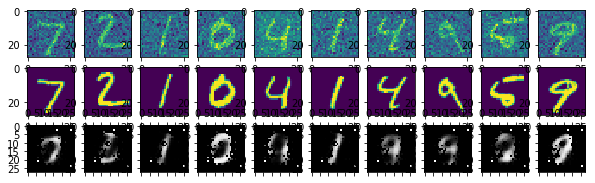

label is 2
Salt and Pepper Noise


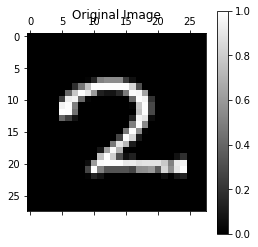

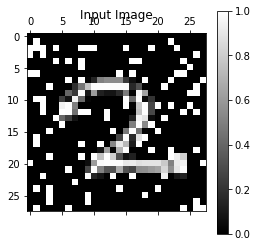

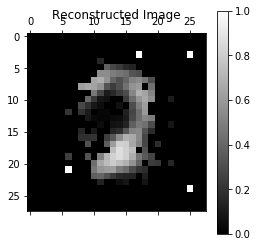

In [25]:
#训练参数
epochs     = 20
batch_size = 256
disp_step  = 2

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    print ("开始训练")
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size, 784)
            feeds = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1.}
            sess.run(optm, feed_dict=feeds)
            total_cost += sess.run(cost, feed_dict=feeds)
            
        # 显示训练日志
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
      
    print ("完成")

    
    show_num = 10
    test_noisy = mnist.test.images[:show_num] + 0.3*np.random.randn(show_num, 784)
    encode_decode = sess.run(
        reconstruction, feed_dict={x: test_noisy, dropout_keep_prob: 1.})
    f, a = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(test_noisy[i], (28, 28)))
        a[1][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[2][i].matshow(np.reshape(encode_decode[i], (28, 28)), cmap=plt.get_cmap('gray'))
    plt.show()
        
    

#换一种噪声测试一个
    randidx   = np.random.randint(test_X.shape[0], size=1)
    orgvec    = test_X[randidx, :]
    testvec   = test_X[randidx, :]
    label     = np.argmax(test_Y[randidx, :], 1)
    
    print ("label is %d" % (label)) 
    # Noise type
  
    print ("Salt and Pepper Noise")
    noisyvec = testvec
    rate     = 0.15
    noiseidx = np.random.randint(test_X.shape[1]
                                 , size=int(test_X.shape[1]*rate))
    noisyvec[0, noiseidx] = 1-noisyvec[0, noiseidx]
    
    outvec   = sess.run(reconstruction, feed_dict={x: noisyvec, dropout_keep_prob: 1})
    outimg   = np.reshape(outvec, (28, 28))
    
    # Plot 
    plt.matshow(np.reshape(orgvec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title("Original Image")
    plt.colorbar()
    
    plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title("Input Image")
    plt.colorbar()
    
    plt.matshow(outimg, cmap=plt.get_cmap('gray'))
    plt.title("Reconstructed Image")
    plt.colorbar()
    plt.show() 